<a href="https://colab.research.google.com/github/NitheshNayak/AnomalyDetection_in_Cyber_Physical_Systems/blob/main/Modbus_Data_Detection_of_Adverserial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of adverserial attack in IoT Network

In [ ]:
# Mounting the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install -r requirements.txt

In [ ]:
# the official Cleverhans library (without future moudule)
!pip install git+https://github.com/cleverhans-lab/cleverhans.git
# !pip install git+https://github.com/CNOCycle/cleverhans.git@feature/tf2.x
# !pip install git+https://github.com/tensorflow/cleverhans/pull/1122

  Cloning https://github.com/cleverhans-lab/cleverhans.git to /tmp/pip-req-build-u3h_mevo
  Running command git clone -q https://github.com/cleverhans-lab/cleverhans.git /tmp/pip-req-build-u3h_mevo
     |████████████████████████████████| 154 kB 4.8 MB/s 
     |████████████████████████████████| 42 kB 515 kB/s 
  Created wheel for cleverhans: filename=cleverhans-4.0.0-py3-none-any.whl size=92423 sha256=6ed0ecedf53671bad1398e54e7f8303eba53e32945e6a30e31dbc478e40ef7a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-urhis8ki/wheels/9b/85/fc/711535dc7ec7166b7a4fa93ac3294df0dcf383f1364af0e3d4
Successfully built cleverhans


In [ ]:
# Libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

import itertools
import imblearn 
from os.path import exists
from collections import Counter
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf # 2.7.0
from tensorflow import keras
from tensorflow.keras.models import load_model

import torch
import torch.nn as nn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

import cleverhans #4.0.0-242afd7ec8f9546baeb1168438446ce1
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

print("\nTensorflow Version: " + tf.__version__)

print("\nCleverhans Version: " + cleverhans.__version__)


Tensorflow Version: 2.8.0

Cleverhans Version: 4.0.0-242afd7ec8f9546baeb1168438446ce1


In [ ]:
# Printing GPU Information
print("GPU Available: ", tf.test.is_gpu_available())

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

GPU Available:  True
Wed Feb 16 17:37:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    479MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                   

In [ ]:
## Confusion Matrix Plot Function : Function is defined here for later use

def plot_confusion_matrix(cm,classes
                          ,normalize=False,
                          title='Confusion Matrix',cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion Matrix without normalization")
        
    print(cm)
    
    thresh = cm.max() /2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')

# **Data Preprocessing**
## Load Data

In [ ]:
# Load the dataset
dataset = pd.read_csv("/content/drive/MyDrive/VRES/Train_Test_IoT_Modbus.csv")
dataset.dropna(inplace=True)

# Check the shape
print("Shape of the input file - ",dataset.shape)
print("\n")

# Print the first 5 lines of the dataset 
dataset.head(5)

Shape of the input file -  (51106, 9)




,ts,date,time,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label,type
0,1556208840,25-Apr-19,09:14:00,49389,52921,25770,13625,1,injection
1,1556208840,25-Apr-19,09:14:00,49389,52921,25770,13625,1,injection
2,1556208841,25-Apr-19,09:14:01,49389,52921,25770,13625,1,injection
3,1556208842,25-Apr-19,09:14:02,49389,52921,25770,13625,1,injection
4,1556208844,25-Apr-19,09:14:04,40665,44748,21098,35371,1,injection


In [ ]:
# Information of the input data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51106 entries, 0 to 51105
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ts                         51106 non-null  int64 
 1   date                       51106 non-null  object
 2   time                       51106 non-null  object
 3   FC1_Read_Input_Register    51106 non-null  int64 
 4   FC2_Read_Discrete_Value    51106 non-null  int64 
 5   FC3_Read_Holding_Register  51106 non-null  int64 
 6   FC4_Read_Coil              51106 non-null  int64 
 7   label                      51106 non-null  int64 
 8   type                       51106 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.9+ MB


In [ ]:
# Check for NUll Values 
dataset.isna().sum()

ts                           0
date                         0
time                         0
FC1_Read_Input_Register      0
FC2_Read_Discrete_Value      0
FC3_Read_Holding_Register    0
FC4_Read_Coil                0
label                        0
type                         0
dtype: int64

In [ ]:
# Check for Duplicates
print("There is no duplicate entries present in the dataset: ", dataset[dataset.duplicated()].shape[0]==0)

There is no duplicate entries present in the dataset:  False


In [ ]:
# Drop duplicates
dataset1 = dataset.drop_duplicates(ignore_index=True)
dataset1

,ts,date,time,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label,type
0,1556208840,25-Apr-19,09:14:00,49389,52921,25770,13625,1,injection
1,1556208841,25-Apr-19,09:14:01,49389,52921,25770,13625,1,injection
2,1556208842,25-Apr-19,09:14:02,49389,52921,25770,13625,1,injection
3,1556208844,25-Apr-19,09:14:04,40665,44748,21098,35371,1,injection
4,1556208846,25-Apr-19,09:14:06,40665,44748,21098,35371,1,injection
...,...,...,...,...,...,...,...,...,...
31357,1554183533,1-Apr-19,22:38:53,62602,1253,12772,29319,0,normal
31358,1554183536,1-Apr-19,22:38:56,62602,1253,12772,29319,0,normal
31359,1554183537,1-Apr-19,22:38:57,198,38266,33649,44594,0,normal
31360,1554183538,1-Apr-19,22:38:58,198,38266,33649,44594,0,normal


## Data Encoding

In [ ]:
# Encode data which is not in numerical form
dataset = dataset1.copy()
stringEncoder= LabelEncoder()
dataset['date'] = stringEncoder.fit_transform(dataset['date'])
dataset['time'] = stringEncoder.fit_transform(dataset['time'])
dataset['type'] = stringEncoder.fit_transform(dataset['type'])
dataset

,ts,date,time,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label,type
0,1556208840,3,1850,49389,52921,25770,13625,1,1
1,1556208841,3,1851,49389,52921,25770,13625,1,1
2,1556208842,3,1852,49389,52921,25770,13625,1,1
3,1556208844,3,1853,40665,44748,21098,35371,1,1
4,1556208846,3,1854,40665,44748,21098,35371,1,1
...,...,...,...,...,...,...,...,...,...
31357,1554183533,0,22910,62602,1253,12772,29319,0,2
31358,1554183536,0,22911,62602,1253,12772,29319,0,2
31359,1554183537,0,22912,198,38266,33649,44594,0,2
31360,1554183538,0,22913,198,38266,33649,44594,0,2


In [ ]:
# Check if "data" column is encoded successfully
dataset.date.unique()

array([3, 6, 7, 4, 2, 5, 0, 1])

## Data Preparation for Model Train and Test

In [ ]:
df = pd.DataFrame(dataset)
print(df.head(5))

# Separate lable column from the overall dataset
x = df.drop('label',axis='columns')
y = df['label']

# Check the classes in the dataset
counter = Counter(y)
print("Class split in the dataset -", counter)

# Save samples and labels into 2 variables 
train_samples, train_labels = x, y

           ts  date  time  ...  FC4_Read_Coil  label  type
0  1556208840     3  1850  ...          13625      1     1
1  1556208841     3  1851  ...          13625      1     1
2  1556208842     3  1852  ...          13625      1     1
3  1556208844     3  1853  ...          35371      1     1
4  1556208846     3  1854  ...          35371      1     1

[5 rows x 9 columns]
Class split in the dataset - Counter({0: 17476, 1: 13886})


In [ ]:
# Data Normalization (MinMax): scale data to make values between 0 and 1
scaler = MinMaxScaler().fit(train_samples)
scaled_x = scaler.transform(train_samples)
pd.DataFrame(scaled_x)

print("After Normalizing with MinMax \n")
print(scaled_x)

After Normalizing with MinMax 

[[0.88775013 0.42857143 0.07839315 ... 0.39328501 0.20790735 0.2       ]
 [0.88775055 0.42857143 0.07843553 ... 0.39328501 0.20790735 0.2       ]
 [0.88775096 0.42857143 0.0784779  ... 0.39328501 0.20790735 0.2       ]
 ...
 [0.0506426  0.         0.9708886  ... 0.51352919 0.68047121 0.4       ]
 [0.05064301 0.         0.97093097 ... 0.51352919 0.68047121 0.4       ]
 [0.05064425 0.         0.97097335 ... 0.51352919 0.68047121 0.4       ]]


In [ ]:
# Encoding the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = np_utils.to_categorical(y_encoded)
print(y_encoded)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
# Data split for train and test with 70:30 split with stratified Sampling 
RANDOM_STATE = 42
TEST_SPLIT = 0.3
train_samples, test_samples, train_labels, test_labels = train_test_split(
    scaled_x, y_encoded, test_size=TEST_SPLIT, random_state=RANDOM_STATE, stratify=y_encoded)
print("Train Set", train_samples.shape, train_labels.shape)
print("Test Set", test_samples.shape, test_labels.shape)

Train Set (21953, 8) (21953, 2)
Test Set (9409, 8) (9409, 2)


### Save Processed Data

In [ ]:
# Save processed data using following code if needed
# train_samples_df = pd.DataFrame(train_samples)
# print(train_samples_df.shape)
# test_samples_df = pd.DataFrame(test_samples)
# print(test_samples_df.shape)

# train_labels_df = pd.DataFrame(train_labels)
# print(train_samples_df.shape)
# test_labels_df = pd.DataFrame(test_labels)
# print(test_labels_df.shape)

# for data in [
#              ["scaled_train_samples.csv", train_samples_df, train_samples.columns.values], 
#              ["train_labels.csv", train_labels_df, train_labels_df.columns.values], 
#              ["scaled_test_samples.csv", test_samples_df, test_samples.columns.values], 
#              ["test_labels.csv", test_labels_df, test_labels_df.columns.values]
#              ]:

#   path = "/content/drive/MyDrive/VRES/Epsilon/" + data[0]
#   if exists(path) == False:
#     data[1].to_csv(path, header=data[2], index=False)

## Read Saved CSV

In [ ]:
# scaled_train_samples = pd.read_csv("/content/drive/MyDrive/VRES/Epsilon/scaled_train_samples.csv")
# train_labels = pd.read_csv("/content/drive/MyDrive/VRES/Epsilon/train_labels.csv")
# scaled_test_samples = pd.read_csv("/content/drive/MyDrive/VRES/Epsilon/scaled_test_samples.csv")
# test_labels = pd.read_csv("/content/drive/MyDrive/VRES/Epsilon/test_labels.csv")

# **Model Architecture and Traning**

In [ ]:
# Model Architecture
model = keras.Sequential(
    [
     keras.layers.Input(shape=(8,)),
     keras.layers.Dense(20, activation='tanh'),
     keras.layers.Dense(60, activation='tanh'),
     keras.layers.Dense(80, activation='tanh'),
     keras.layers.Dense(90, activation='tanh'),
     keras.layers.Dense(2, activation='sigmoid') 
    ]
  )

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

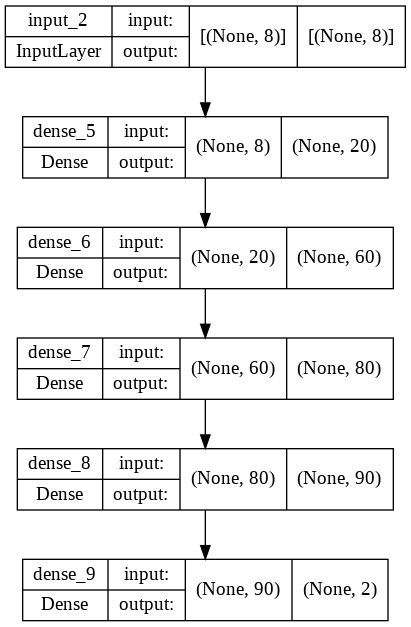

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Model summery 
print(model.input_shape)
print(model.summary())

(None, 8)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 20)                180       
                                                                 
 dense_6 (Dense)             (None, 60)                1260      
                                                                 
 dense_7 (Dense)             (None, 80)                4880      
                                                                 
 dense_8 (Dense)             (None, 90)                7290      
                                                                 
 dense_9 (Dense)             (None, 2)                 182       
                                                                 
Total params: 13,792
Trainable params: 13,792
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Model hyperparameters
BATCH_SIZE = 32
EPOCH = 3
VERBOSE = 1
VALIDATION_SPLIT = 0.4
RANDOM_STATE = 42
LEARNING_RATE = 0.001
MODEL_PATH = "/content/drive/MyDrive/VRES/Modbus/model_modbus.h5"

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# Train the model 
model.fit(x=train_samples, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCH, 
          verbose=1, validation_split=VALIDATION_SPLIT, shuffle=True) 

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


412/412 [==============================] - 6s 6ms/step - loss: 0.6088 - accuracy: 0.8015 - val_loss: 0.5124 - val_accuracy: 0.9151
Epoch 2/3
412/412 [==============================] - 2s 6ms/step - loss: 0.4331 - accuracy: 0.9388 - val_loss: 0.3591 - val_accuracy: 0.9573
Epoch 3/3
412/412 [==============================] - 2s 6ms/step - loss: 0.2955 - accuracy: 0.9759 - val_loss: 0.2409 - val_accuracy: 0.9834


In [ ]:
# Save the model
if exists(MODEL_PATH) == False:
  model.save(MODEL_PATH)

## Model Predictions

Model Evalution:
295/295 [==============================] - 1s 3ms/step - loss: 0.2438 - accuracy: 0.9810
[0.24380145967006683, 0.9809756875038147]


Modle Prediction...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      5243
           1       1.00      0.97      0.98      4166

   micro avg       0.98      0.98      0.98      9409
   macro avg       0.98      0.98      0.98      9409
weighted avg       0.98      0.98      0.98      9409
 samples avg       0.98      0.98      0.98      9409

Confusion Matrix without normalization
[[5243    0]
 [ 194 3972]]


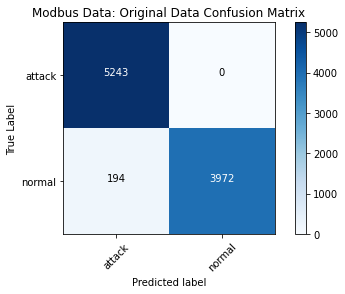

In [ ]:
# Model prediction
print("Model Evalution:")
print(model.evaluate(test_samples, test_labels))
print("\n")

print("Modle Prediction...")    
pred_Main1 = model.predict(test_samples)
pred_Main = np.round(pred_Main1)
print("Classification Report: \n",classification_report(test_labels, pred_Main))

cm = confusion_matrix(test_labels.argmax(axis=1), pred_Main.argmax(axis=1))
CM_PLOT_LABLES = ['attack','normal'] # Confusion matrix lables defined here
plot_confusion_matrix(cm=cm, classes=CM_PLOT_LABLES, title="Modbus Data: Original Data Confusion Matrix")

# **FGSM and Prediction**

In [ ]:
# Load the Model: Load model when we need to use it after restarting runtime. 
model = load_model("/content/drive/MyDrive/VRES/Modbus/model_modbus.h5")

CM_PLOT_LABLES = ['attack','normal'] # Class lables for Confusion Matix

# Create a list for saving accuracy
adv_acc = []

# Check model shape
model.layers[-1].output
model.input

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'input_1')>

In [ ]:
# Logits Model as given in - https://arxiv.org/abs/2104.12426
logits_model = tf.keras.Model(model.input, model.layers[-1].output)
logits_model

In [ ]:
# Convert the Test samples to tensor
original_data = test_samples
original_data = tf.convert_to_tensor(original_data.reshape((len(test_samples), 8)))
original_data

<tf.Tensor: shape=(9409, 8), dtype=float64, numpy=
array([[9.95612973e-01, 8.57142857e-01, 1.29073266e-01, ...,
        2.89126288e-01, 2.02948088e-03, 0.00000000e+00],
       [1.41770335e-04, 1.00000000e+00, 9.93643798e-01, ...,
        6.64860740e-01, 2.50724815e-01, 4.00000000e-01],
       [1.24410702e-04, 1.00000000e+00, 9.91864062e-01, ...,
        4.70980542e-01, 3.34299753e-01, 4.00000000e-01],
       ...,
       [4.30374232e-02, 0.00000000e+00, 6.77274461e-01, ...,
        7.65906143e-01, 7.93633839e-02, 4.00000000e-01],
       [4.47105612e-02, 0.00000000e+00, 7.81982287e-01, ...,
        5.00312858e-01, 1.06814783e-03, 4.00000000e-01],
       [8.88170071e-01, 4.28571429e-01, 1.07123183e-01, ...,
        1.75780237e-01, 8.25830866e-02, 2.00000000e-01]])>

Model Evaluation : 
 18/295 [>.............................] - ETA: 0s - loss: 0.3887 - accuracy: 0.9861 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


295/295 [==============================] - 1s 3ms/step - loss: 0.3839 - accuracy: 0.9784
[0.383854478597641, 0.9784249067306519]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      5243
           1       1.00      0.98      0.99      4166

   micro avg       0.96      0.99      0.98      9409
   macro avg       0.97      0.99      0.98      9409
weighted avg       0.97      0.99      0.98      9409
 samples avg       0.98      0.99      0.98      9409

Confusion Matrix without normalization
[[5243    0]
 [ 351 3815]]


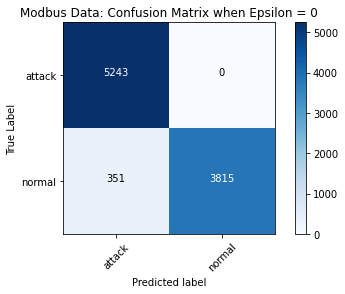

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS= 0 

# Generate adversarial samples
adv_data_0 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_0, test_labels))

pred0 = model.predict(adv_data_0)
pred0 = np.round(pred0)
print("Classification Report: \n", classification_report(test_labels, pred0))

# The confusion matrix
cm0 = confusion_matrix(test_labels.argmax(axis=1), pred0.argmax(axis=1))
plot_confusion_matrix(cm=cm0, classes=CM_PLOT_LABLES, title="Modbus Data: Confusion Matrix when Epsilon = 0")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred0)) # Saving the prediction accuracy



---



---



Model Evaluation : 
295/295 [==============================] - 1s 3ms/step - loss: 0.6390 - accuracy: 0.6993
[0.638979434967041, 0.6993304491043091]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.65      0.65      5243
           1       0.85      0.62      0.72      4166

   micro avg       0.72      0.64      0.68      9409
   macro avg       0.75      0.64      0.69      9409
weighted avg       0.74      0.64      0.68      9409
 samples avg       0.62      0.64      0.63      9409

Confusion Matrix without normalization
[[4796  447]
 [1944 2222]]


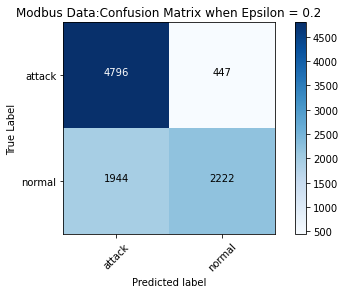

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS= 0.2

# Generate adversarial samples
adv_data_1 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_1, test_labels))

pred1 = model.predict(adv_data_1)
pred1 = np.round(pred1)
print("Classification Report: \n", classification_report(test_labels, pred1))

# The confusion matrix
cm1 = confusion_matrix(test_labels.argmax(axis=1), pred1.argmax(axis=1))
plot_confusion_matrix(cm=cm1, classes=CM_PLOT_LABLES, title="Modbus Data:Confusion Matrix when Epsilon = 0.2")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred1))



---



---



Model Evaluation : 
295/295 [==============================] - 1s 3ms/step - loss: 0.9847 - accuracy: 0.0368
[0.9846563935279846, 0.03677330166101456]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      5243
           1       0.05      0.05      0.05      4166

   micro avg       0.03      0.03      0.03      9409
   macro avg       0.03      0.03      0.03      9409
weighted avg       0.02      0.03      0.02      9409
 samples avg       0.03      0.03      0.03      9409

Confusion Matrix without normalization
[[ 806 4437]
 [3948  218]]


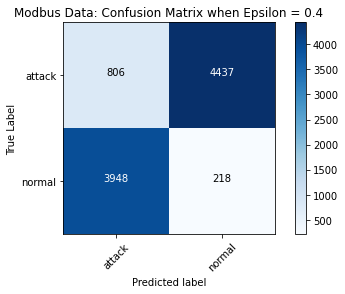

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS= 0.4

# Generate adversarial samples
adv_data_2 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_2, test_labels))

pred2 = model.predict(adv_data_2)
pred2 = np.round(pred2)
print("Classification Report: \n", classification_report(test_labels, pred2))

# The confusion matrix
cm2 = confusion_matrix(test_labels.argmax(axis=1), pred2.argmax(axis=1))
plot_confusion_matrix(cm=cm2, classes=CM_PLOT_LABLES, title="Modbus Data: Confusion Matrix when Epsilon = 0.4")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred2))



---



---



Model Evaluation : 
295/295 [==============================] - 1s 3ms/step - loss: 1.3223 - accuracy: 0.0216
[1.3222792148590088, 0.021575087681412697]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      5243
           1       0.04      0.05      0.04      4166

   micro avg       0.02      0.02      0.02      9409
   macro avg       0.02      0.02      0.02      9409
weighted avg       0.02      0.02      0.02      9409
 samples avg       0.02      0.02      0.02      9409

Confusion Matrix without normalization
[[   0 5243]
 [3963  203]]


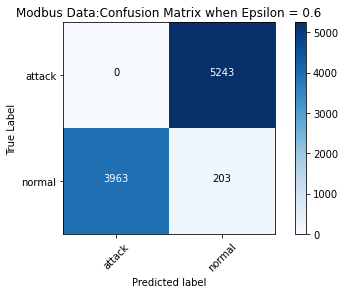

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS= 0.6

# Generate adversarial samples
adv_data_3 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_3, test_labels))

pred3 = model.predict(adv_data_3)
pred3 = np.round(pred3)
print("Classification Report: \n", classification_report(test_labels, pred3))

# The confusion matrix
cm3 = confusion_matrix(test_labels.argmax(axis=1), pred3.argmax(axis=1))
plot_confusion_matrix(cm=cm3, classes=CM_PLOT_LABLES, title="Modbus Data:Confusion Matrix when Epsilon = 0.6")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred3))



---



---



Model Evaluation : 
295/295 [==============================] - 1s 3ms/step - loss: 1.5894 - accuracy: 0.0216
[1.5893570184707642, 0.021575087681412697]
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      5243
           1       0.04      0.05      0.04      4166

   micro avg       0.02      0.02      0.02      9409
   macro avg       0.02      0.02      0.02      9409
weighted avg       0.02      0.02      0.02      9409
 samples avg       0.02      0.02      0.02      9409

Confusion Matrix without normalization
[[   0 5243]
 [3963  203]]


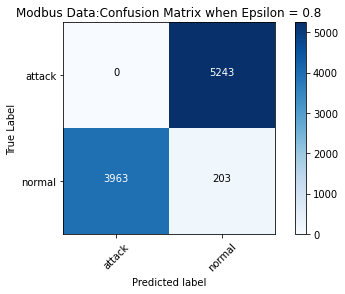

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS= 0.8

# Generate adversarial samples
adv_data_4 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_4, test_labels))

pred4 = model.predict(adv_data_4)
pred4 = np.round(pred4)
print("Classification Report: \n", classification_report(test_labels, pred4))

# The confusion matrix
cm4 = confusion_matrix(test_labels.argmax(axis=1), pred4.argmax(axis=1))
plot_confusion_matrix(cm=cm4, classes=CM_PLOT_LABLES, title="Modbus Data:Confusion Matrix when Epsilon = 0.8")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred4))



---



---



Model Evaluation : 
295/295 [==============================] - 1s 3ms/step - loss: 1.7794 - accuracy: 0.0216
[1.779352068901062, 0.021575087681412697]
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      5243
           1       0.04      0.05      0.04      4166

   micro avg       0.02      0.02      0.02      9409
   macro avg       0.02      0.02      0.02      9409
weighted avg       0.02      0.02      0.02      9409
 samples avg       0.02      0.02      0.02      9409

Confusion Matrix without normalization
[[   0 5243]
 [3963  203]]


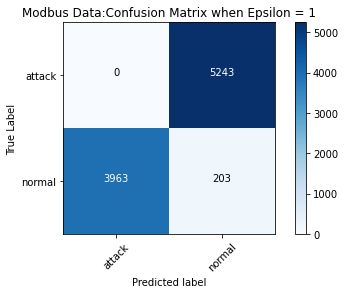

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS = 1

# Generate adversarial samples
adv_data_5 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_5, test_labels))

pred5 = model.predict(adv_data_5)
pred5 = np.round(pred5)
print("Classification Report: \n", classification_report(test_labels, pred5))

# The confusion matrix
cm5 = confusion_matrix(test_labels.argmax(axis=1), pred5.argmax(axis=1))
plot_confusion_matrix(cm=cm5, classes=CM_PLOT_LABLES, title="Modbus Data:Confusion Matrix when Epsilon = 1")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred5))

# **Epsilon Value VS. Accuracy**

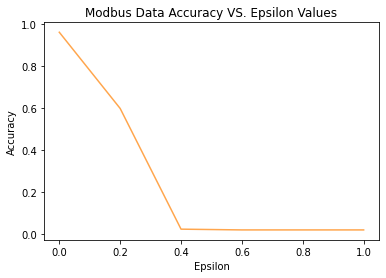

In [ ]:
plt.plot(np.linspace(0, 1, 6, True), adv_acc, color='#ffa64d')
plt.title('Modbus Data Accuracy VS. Epsilon Values')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

# Retrain Model 
Retrain model with samples including various percentage of adversarial samples.

## Experiment 1

We have 70% for training and 30% for testing. Now we are going to split the 70% into 60% and 10%, and use the 10% to generate adversarial samples. 

In [ ]:
# Retain from "FGSM and Prediction"
CM_PLOT_LABLES = ['attack','normal'] # Class lables for Confusion Matix

In [ ]:
# Logits Model as given in - https://arxiv.org/abs/2104.12426
logits_model = tf.keras.Model(model.input, model.layers[-1].output)
logits_model

In [ ]:
# Parameters
EPS = 1 # Epsilon Value
RANDOM_STATE = 42
TRAIN_ADVERSERIAL_SIZE = 0.1
# TEST_ADVERSERIAL_SIZE = 1.0

# Adding adverserial samples to train set 

norm_samples1, adv_samples1, norm_labels1, adv_labels1 = train_test_split(
    train_samples, train_labels, test_size=TRAIN_ADVERSERIAL_SIZE, 
    random_state=RANDOM_STATE, stratify=train_labels) # Making the train and adverserial sample split 

original_data = adv_samples1.copy()
original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples1), 8))) # Convert to part of train samples to tensor

adv_samples1 = fast_gradient_method(logits_model, original_data,EPS, np.inf) # Run fast_gradient_method on the tensor train sample 

# Concatenate split train data
exp_train_samples1 = tf.concat((norm_samples1, adv_samples1), 0)
exp_train_labels1 = np.concatenate((norm_labels1, adv_labels1), axis=0)
exp_train_samples1 = exp_train_samples1.numpy() # Convert to numpy for shuffling 

# Shuffle train data
exp_train_samples1, exp_train_labels1 = shuffle(exp_train_samples1, 
                                                exp_train_labels1, random_state=RANDOM_STATE)

# # Add Adverserial Samples to test set 
# norm_samples, adv_samples, norm_labels, adv_labels = train_test_split(
#     test_samples, test_labels, test_size=TEST_ADVERSERIAL_SIZE, 
#     random_state=RANDOM_STATE, stratify=test_labels) # Making the train and adverserial sample split 

# original_data = adv_samples.copy()
# original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples), 8))) # Convert to part of test samples to tensor

# adv_samples1 = fast_gradient_method(logits_model, original_data, EPS, np.inf) # Run fast_gradient_method on the tensor test sample 

# # Concatenate split test data
# exp_test_samples = tf.concat((norm_samples, adv_samples), 0)
# exp_test_labels = tf.concat((norm_labels, adv_labels), 0)
# exp_test_samples = exp_test_samples.numpy() # Convert to numpy for shuffling 
# exp_test_labels = exp_test_labels.numpy()


# Add Adverserial Samples to test set 
adv_samples1, adv_labels1 = test_samples, test_labels # Making the train and adverserial sample split 

original_data = adv_samples1.copy()
original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples1), 8))) # Convert to part of test samples to tensor

adv_samples1 = fast_gradient_method(logits_model, original_data, EPS, np.inf) # Run fast_gradient_method on the tensor test sample 

# Convert to numpy for shuffling
exp_test_samples1 = adv_samples1.numpy()  
exp_test_labels1 = adv_labels1.copy()

# Shuffle test data
exp_test_samples, exp_test_labels = shuffle(exp_test_samples1, 
                                            exp_test_labels1, random_state=RANDOM_STATE)

In [ ]:
# Convert test and train samples to tensor
exp_train_samples1 = tf.convert_to_tensor(exp_train_samples1)
exp_test_samples1 = tf.convert_to_tensor(exp_test_samples)

print("Train Samples - ", exp_train_samples1.shape, exp_train_labels1.shape)
print("Test Samples - ", exp_test_samples1.shape, exp_test_labels.shape)

Train Samples -  (21953, 8) (21953, 2)
Test Samples -  (9409, 8) (9409, 2)


In [ ]:
# Model training
# Model hyperparameters
BATCH_SIZE = 32
EPOCH = 3
VERBOSE = 1
VALIDATION_SPLIT = 0.4

model.fit(x=exp_train_samples1, y=exp_train_labels1, batch_size=BATCH_SIZE, epochs=EPOCH, 
          verbose=1, validation_split=VALIDATION_SPLIT, shuffle=True)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


412/412 [==============================] - 2s 5ms/step - loss: 0.7138 - accuracy: 0.4678 - val_loss: 0.6750 - val_accuracy: 0.5823
Epoch 2/3
412/412 [==============================] - 2s 4ms/step - loss: 0.6431 - accuracy: 0.6772 - val_loss: 0.6114 - val_accuracy: 0.7765
Epoch 3/3
412/412 [==============================] - 2s 5ms/step - loss: 0.5788 - accuracy: 0.8245 - val_loss: 0.5463 - val_accuracy: 0.8574


Predict after fitting mixed data to the model

Model Evaluation .. 
295/295 [==============================] - 1s 3ms/step - loss: 0.7033 - accuracy: 0.5994
[0.7033448815345764, 0.5994260907173157]
Model Prediction....


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.61      0.85      0.71      5243
           1       0.54      0.34      0.42      4166

   micro avg       0.60      0.62      0.61      9409
   macro avg       0.58      0.59      0.56      9409
weighted avg       0.58      0.62      0.58      9409
 samples avg       0.58      0.62      0.59      9409

Confusion Matrix without normalization
[[4681  562]
 [2936 1230]]


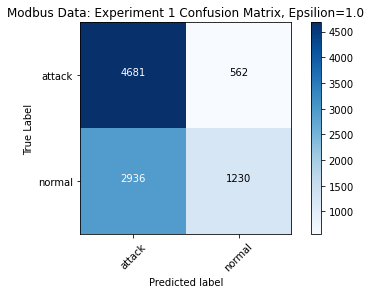

In [ ]:
# Predict after fitting mixed data to the model
print("Model Evaluation .. ")
print(model.evaluate(exp_test_samples, exp_test_labels))

print("Model Prediction....")
exp_pred1 = model.predict(exp_test_samples)
exp_pred1 = np.round(exp_pred1)

print("Classification Report: \n",classification_report(exp_test_labels, exp_pred1))
exp1= confusion_matrix(exp_test_labels.argmax(axis=1), exp_pred1.argmax(axis=1))
plot_confusion_matrix(cm=exp1, classes=CM_PLOT_LABLES, title="Modbus Data: Experiment 1 Confusion Matrix, Epsilion=1.0")

## Experiment 2

In [ ]:
# Retain from "FGSM and Prediction"
CM_PLOT_LABLES = ['attack','normal'] # Class lables for Confusion Matix

In [ ]:
# Logits Model as given in - https://arxiv.org/abs/2104.12426
logits_model = tf.keras.Model(model.input, model.layers[-1].output)
logits_model

In [ ]:
# Parameters

EPS = 1 # Epsilon Value
RANDOM_STATE = 42
TRAIN_ADVERSERIAL_SIZE = 0.2
# TEST_ADVERSERIAL_SIZE = 1.0

# Adding Adverserial Samples to train set 

norm_samples, adv_samples2, norm_labels, adv_labels2 = train_test_split(
    train_samples, train_labels, test_size=TRAIN_ADVERSERIAL_SIZE, 
    random_state=RANDOM_STATE, stratify=train_labels) # Making the train and adverserial sample split 

original_data = adv_samples2.copy()
original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples2), 8))) #Convert to part of train samples to tensor

adv_samples2 = fast_gradient_method(logits_model, original_data,EPS, np.inf) # Run fast_gradient_method on the tensor train sample 

# Concatenate split train data
exp_train_samples2 = tf.concat((norm_samples, adv_samples2), 0)
exp_train_labels2 = np.concatenate((norm_labels, adv_labels2), axis=0)
exp_train_samples2 = exp_train_samples2.numpy()

# Shuffle train data
exp_train_samples2, exp_train_labels2 = shuffle(exp_train_samples2, exp_train_labels2, random_state=RANDOM_STATE)

# We have kept the test size split same as experiment 1 
# # Add Adverserial Samples to test set 
# norm_samples, adv_samples, norm_labels, adv_labels = train_test_split(
#     test_samples, test_labels, test_size=TEST_ADVERSERIAL_SIZE, 
#     random_state=RANDOM_STATE, stratify=test_labels) # Making the train and adverserial sample split 

# original_data = adv_samples.copy()
# original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples), 8))) # Convert to part of test samples to tensor

# adv_samples1 = fast_gradient_method(logits_model, original_data, EPS, np.inf) # Run fast_gradient_method on the tensor test sample 

# # Concatenate split test data
# exp_test_samples = tf.concat((norm_samples, adv_samples), 0)
# exp_test_labels = tf.concat((norm_labels, adv_labels), 0)
# exp_test_samples = exp_test_samples.numpy() # Convert to numpy for shuffling 
# exp_test_labels = exp_test_labels.numpy()

# # Shuffle test data
# exp_test_samples, exp_test_labels = shuffle(exp_test_samples, 
#                                             exp_test_labels, random_state=RANDOM_STATE)

# Add Adverserial Samples to test set 
adv_samples2, adv_labels2 = test_samples, test_labels # Making the train and adverserial sample split 

original_data2 = adv_samples2.copy()
original_data2 = tf.convert_to_tensor(original_data2.reshape((len(adv_samples), 8))) # Convert to part of test samples to tensor

adv_samples21 = fast_gradient_method(logits_model, original_data2, EPS, np.inf) # Run fast_gradient_method on the tensor test sample 

# Concatenate split test data

exp_test_samples2 = adv_samples21.numpy() # Convert to numpy for shuffling 
exp_test_labels2 = adv_labels2.copy()

# Shuffle test data
exp_test_samples, exp_test_labels = shuffle(exp_test_samples2, 
                                            exp_test_labels2, random_state=RANDOM_STATE)

In [ ]:
# Convert test and train samples to tensor
exp_train_samples2 = tf.convert_to_tensor(exp_train_samples2)
exp_test_samples2 = tf.convert_to_tensor(exp_test_samples)

print("Train Samples - ", exp_train_samples2.shape, exp_train_labels2.shape)
print("Test Samples - ", exp_test_samples2.shape, exp_test_labels.shape)

Train Samples -  (21953, 8) (21953, 2)
Test Samples -  (9409, 8) (9409, 2)


In [ ]:
# Model training
# Model hyperparameters
BATCH_SIZE = 32
EPOCH = 3
VERBOSE = 1
VALIDATION_SPLIT = 0.4

model.fit(x=exp_train_samples2, y=exp_train_labels2, batch_size=BATCH_SIZE, epochs=EPOCH, 
          verbose=VERBOSE, validation_split=VALIDATION_SPLIT, shuffle=True)

Epoch 1/3
412/412 [==============================] - 3s 8ms/step - loss: 0.5017 - accuracy: 0.8043 - val_loss: 0.3908 - val_accuracy: 0.7936
Epoch 2/3
412/412 [==============================] - 2s 6ms/step - loss: 0.3089 - accuracy: 0.8922 - val_loss: 0.2585 - val_accuracy: 0.9668
Epoch 3/3
412/412 [==============================] - 2s 6ms/step - loss: 0.2198 - accuracy: 0.9729 - val_loss: 0.1952 - val_accuracy: 0.9780


Model Evaluation
295/295 [==============================] - 1s 3ms/step - loss: 0.3868 - accuracy: 0.8865
[0.38683220744132996, 0.8864916563034058]
Model Prediction...
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.99      0.91      5243
           1       0.99      0.76      0.86      4166

   micro avg       0.88      0.89      0.89      9409
   macro avg       0.91      0.88      0.88      9409
weighted avg       0.90      0.89      0.88      9409
 samples avg       0.89      0.89      0.89      9409

Confusion Matrix without normalization
[[5216   27]
 [1064 3102]]


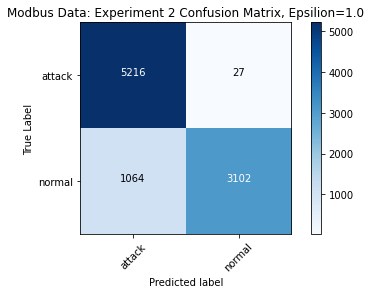

In [ ]:
# Predict after fitting mixed data to the model
print("Model Evaluation")
print(model.evaluate(exp_test_samples2, exp_test_labels))

print("Model Prediction...")
exp_pred2 = model.predict(exp_test_samples2)
exp_pred2 = np.round(exp_pred2)

print("Classification Report: \n",classification_report(exp_test_labels, exp_pred2))
exp2= confusion_matrix(exp_test_labels.argmax(axis=1), exp_pred2.argmax(axis=1))
plot_confusion_matrix(cm=exp2, classes=CM_PLOT_LABLES, title="Modbus Data: Experiment 2 Confusion Matrix, Epsilion=1.0")

## Experiment 3

In [ ]:
# Retain from "FGSM and Prediction"
CM_PLOT_LABLES = ['attack','normal'] # Class lables for Confusion Matix

In [ ]:
# Logits Model as given in - https://arxiv.org/abs/2104.12426
logits_model = tf.keras.Model(model.input, model.layers[-1].output)
logits_model

In [ ]:
# Parameters

EPS = 1 # Epsilon Value
RANDOM_STATE = 42
TRAIN_ADVERSERIAL_SIZE = 0.3
# TEST_ADVERSERIAL_SIZE = 1.0

# Adding Adverserial Samples to train set 

norm_samples, adv_samples3, norm_labels, adv_labels3 = train_test_split(
    train_samples, train_labels, test_size=TRAIN_ADVERSERIAL_SIZE, 
    random_state=RANDOM_STATE, stratify=train_labels) # Making the train and adverserial sample split 

original_data = adv_samples3.copy()
original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples3), 8))) #Convert to part of train samples to tensor

adv_samples3 = fast_gradient_method(logits_model, original_data,EPS, np.inf) # Run fast_gradient_method on the tensor train sample 

# Concatenate split train data
exp_train_samples3 = tf.concat((norm_samples, adv_samples3), 0)
exp_train_labels3 = np.concatenate((norm_labels, adv_labels3), axis=0)
exp_train_samples3 = exp_train_samples3.numpy()

# Shuffle train data
exp_train_samples3, exp_train_labels3 = shuffle(exp_train_samples3, exp_train_labels3, random_state=RANDOM_STATE)

# We have kept the test size split same as experiment 1 
# # Add Adverserial Samples to test set 
# norm_samples, adv_samples, norm_labels, adv_labels = train_test_split(
#     test_samples, test_labels, test_size=TEST_ADVERSERIAL_SIZE, 
#     random_state=RANDOM_STATE, stratify=test_labels) # Making the train and adverserial sample split 

# original_data = adv_samples.copy()
# original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples), 8))) # Convert to part of test samples to tensor

# adv_samples1 = fast_gradient_method(logits_model, original_data, EPS, np.inf) # Run fast_gradient_method on the tensor test sample 

# # Concatenate split test data
# exp_test_samples = tf.concat((norm_samples, adv_samples), 0)
# exp_test_labels = tf.concat((norm_labels, adv_labels), 0)
# exp_test_samples = exp_test_samples.numpy() # Convert to numpy for shuffling 
# exp_test_labels = exp_test_labels.numpy()

# # Shuffle test data
# exp_test_samples, exp_test_labels = shuffle(exp_test_samples, 
#                                             exp_test_labels, random_state=RANDOM_STATE)

# Add Adverserial Samples to test set 
adv_samples3, adv_labels3 = test_samples, test_labels # Making the train and adverserial sample split 

original_data3 = adv_samples3.copy()
original_data3 = tf.convert_to_tensor(original_data3.reshape((len(adv_samples3), 8))) # Convert to part of test samples to tensor

adv_samples3 = fast_gradient_method(logits_model, original_data3, EPS, np.inf) # Run fast_gradient_method on the tensor test sample 

# Concatenate split test data

exp_test_samples3 = adv_samples3.numpy() # Convert to numpy for shuffling 
exp_test_labels3 = adv_labels3.copy()

# Shuffle test data
exp_test_samples, exp_test_labels = shuffle(exp_test_samples3, 
                                            exp_test_labels3, random_state=RANDOM_STATE)

In [ ]:
# Convert test and train samples to tensor
exp_train_samples3 = tf.convert_to_tensor(exp_train_samples3)
exp_test_samples3 = tf.convert_to_tensor(exp_test_samples)

print("Train Samples - ", exp_train_samples3.shape, exp_train_labels3.shape)
print("Test Samples - ", exp_test_samples3.shape, exp_test_labels.shape)

Train Samples -  (21953, 8) (21953, 2)
Test Samples -  (9409, 8) (9409, 2)


In [ ]:
# Model training
# Model hyperparameters
BATCH_SIZE = 32
EPOCH = 3
VERBOSE = 1
VALIDATION_SPLIT = 0.4

model.fit(x=exp_train_samples3, y=exp_train_labels3, batch_size=BATCH_SIZE, epochs=EPOCH, 
          verbose=VERBOSE, validation_split=VALIDATION_SPLIT, shuffle=True)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


412/412 [==============================] - 6s 8ms/step - loss: 0.6748 - accuracy: 0.5918 - val_loss: 0.6513 - val_accuracy: 0.6768
Epoch 2/3
412/412 [==============================] - 3s 7ms/step - loss: 0.6264 - accuracy: 0.7752 - val_loss: 0.6035 - val_accuracy: 0.8327
Epoch 3/3
412/412 [==============================] - 3s 6ms/step - loss: 0.5767 - accuracy: 0.8667 - val_loss: 0.5507 - val_accuracy: 0.8812


Model Evaluation
295/295 [==============================] - 1s 3ms/step - loss: 0.5638 - accuracy: 0.8263
[0.5638227462768555, 0.8263365030288696]
Model Prediction...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.83      0.81      5243
           1       0.75      0.88      0.81      4166

   micro avg       0.77      0.85      0.81      9409
   macro avg       0.77      0.85      0.81      9409
weighted avg       0.77      0.85      0.81      9409
 samples avg       0.80      0.85      0.81      9409

Confusion Matrix without normalization
[[4400  843]
 [1204 2962]]


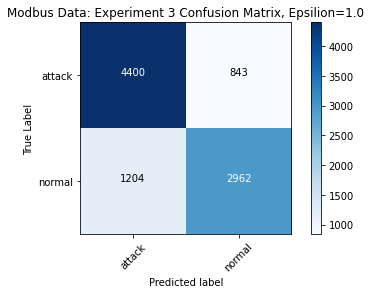

In [ ]:
# Predict after fitting mixed data to the model
print("Model Evaluation")
print(model.evaluate(exp_test_samples3, exp_test_labels))

print("Model Prediction...")
exp_pred3 = model.predict(exp_test_samples3)
exp_pred3 = np.round(exp_pred3)

print("Classification Report: \n",classification_report(exp_test_labels, exp_pred3))
exp3= confusion_matrix(exp_test_labels.argmax(axis=1), exp_pred3.argmax(axis=1))
plot_confusion_matrix(cm=exp3, classes=CM_PLOT_LABLES, title="Modbus Data: Experiment 3 Confusion Matrix, Epsilion=1.0")